## Wind Forecasting Temporal Convolutional Network (TCN)

This is an exploration of the following paper [**Wind Power Forecasting with Deep Learning Networks: Time-Series Forecasting**](https://www.mdpi.com/2076-3417/11/21/10335) for learning purposes :) 

In [1]:
import pandas as pd
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

In [17]:
time_series_data = pd.read_csv('T1.csv')
time_series_data["Date/Time"] = pd.to_datetime(time_series_data["Date/Time"], format='%d %m %Y %H:%M')
time_series_data.set_index('Date/Time', inplace=True)

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
dtype: object

In [20]:
time_series_data = time_series_data.astype('float32')

In [21]:
time_series_data.dtypes

LV ActivePower (kW)              float32
Wind Speed (m/s)                 float32
Theoretical_Power_Curve (KWh)    float32
Wind Direction (°)               float32
dtype: object

In [22]:
series = TimeSeries.from_dataframe(time_series_data, fill_missing_dates=True, freq='10min')

In [23]:
series = fill_missing_values(series)

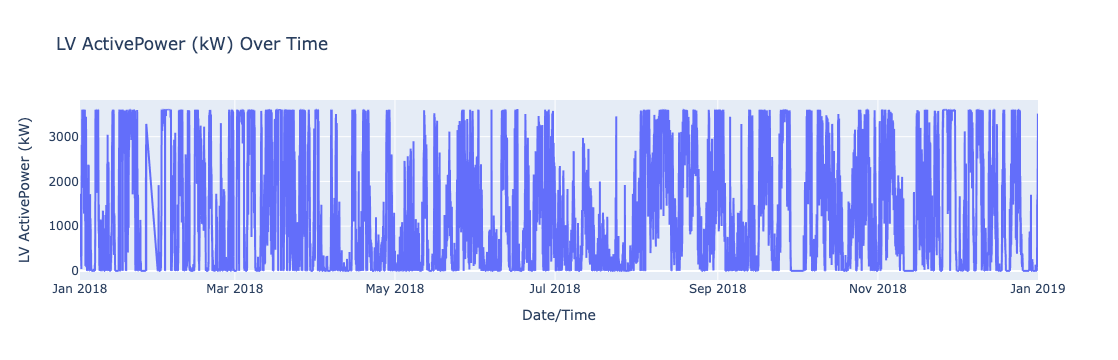

In [24]:
import plotly.express as px

fig = px.line(time_series_data.reset_index(), x='Date/Time', y='LV ActivePower (kW)', title='LV ActivePower (kW) Over Time')
fig.show()

In [25]:
# Test. From this article https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/#:~:text=A%20TCN%2C%20short%20for%20Temporal,same%20input%20and%20output%20lengths.
# There seems to be some sort of pattern across days/months? Let's try encoding that into the series in the future

In [26]:
# Split into test and training datasets. The paper uses up to 12/26/18 (inclusive) as training and 27-29th as val
train, val = series.split_after(pd.Timestamp('20181226'))

from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [46]:
print(val_transformed.values().shape)

(863, 4)


In [77]:
from darts.models import TCNModel

model = TCNModel(
    n_epochs=20, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=16,
    num_filters=4,
    random_state=0,
    input_chunk_length=20000,
    output_chunk_length=val_transformed.values().shape[0],
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)

model.fit(train_transformed['LV ActivePower (kW)'], past_covariates=train_transformed[['Wind Speed (m/s)', 'Wind Direction (°)']])

/Users/olivia.qin/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning:

`torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 5.0 K  | train
-------------------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
58        Mod

Epoch 13:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 818/964 [00:40<00:07, 20.43it/s, train_loss=0.0146]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [73]:
pred = model.predict(val_transformed.values().shape[0])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


In [74]:
print(pred)

<TimeSeries (DataArray) (Date/Time: 863, component: 1, sample: 1)> Size: 3kB
array([[[ 5.70622802e-01]],

       [[ 5.51634550e-01]],

       [[ 4.85636264e-01]],

       [[ 4.86979485e-01]],

       [[ 5.05585194e-01]],

       [[ 5.05114079e-01]],

       [[ 3.76217365e-01]],

       [[ 4.00794089e-01]],

       [[ 4.08723474e-01]],

       [[ 3.43414575e-01]],

...

       [[ 9.66111422e-01]],

       [[ 1.00903678e+00]],

       [[ 9.56952274e-01]],

       [[ 1.00686383e+00]],

       [[ 1.10496819e+00]],

       [[ 1.11479342e+00]],

       [[ 1.07184672e+00]],

       [[ 1.12267113e+00]],

       [[ 1.11660302e+00]],

       [[ 1.05135751e+00]]], dtype=float32)
Coordinates:
  * Date/Time  (Date/Time) datetime64[ns] 7kB 2018-12-26T00:10:00 ... 2018-12...
  * component  (component) object 8B 'LV ActivePower (kW)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [68]:
print(val_transformed['LV ActivePower (kW)'])

<TimeSeries (DataArray) (Date/Time: 863, component: 1, sample: 1)> Size: 3kB
array([[[1.02712855e-01]],

       [[9.52547193e-02]],

       [[1.05584629e-01]],

       [[9.64276716e-02]],

       [[9.95911509e-02]],

       [[9.53008085e-02]],

       [[8.21098089e-02]],

       [[7.15097189e-02]],

       [[9.72257778e-02]],

       [[7.95791969e-02]],

...

       [[7.65927911e-01]],

       [[9.21320736e-01]],

       [[9.54863131e-01]],

       [[9.47611094e-01]],

       [[9.71152186e-01]],

       [[8.19189429e-01]],

       [[4.65818644e-01]],

       [[6.08520865e-01]],

       [[6.95394516e-01]],

       [[7.79557645e-01]]], dtype=float32)
Coordinates:
  * Date/Time  (Date/Time) datetime64[ns] 7kB 2018-12-26T00:10:00 ... 2018-12...
  * component  (component) object 8B 'LV ActivePower (kW)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


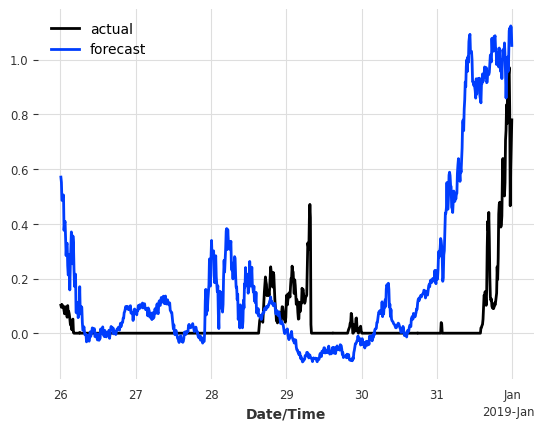

In [76]:
import matplotlib.pyplot as plt

val_transformed['LV ActivePower (kW)'].plot(label="actual")
pred.plot(label="forecast")
plt.legend()

In [9]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
time_series_data_features = time_series_data[['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(time_series_data_features)

# Create a PCA object, specifying the number of components you want
pca = PCA()

# Fit the PCA model to the standardized data
pca.fit(X_scaled)

# Transform the data to the new PCA space
X_pca = pca.transform(X_scaled)

In [22]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=time_series_data_features.columns)
print(loadings)

                                    PC1       PC2       PC3
Wind Speed (m/s)               0.700485  0.102705 -0.706238
Theoretical_Power_Curve (KWh)  0.701964  0.079325  0.707781
Wind Direction (°)            -0.128715  0.991544  0.016529


In [23]:
pca.explained_variance_ratio_

array([0.65346202, 0.3280262 , 0.01851179])

In [25]:
time_series_data.dtypes

Date/Time                         object
LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
dtype: object

In [27]:
time_series_data["Date/Time"] = pd.to_datetime(time_series_data["Date/Time"], format='%d %m %Y %H:%M')

In [28]:
time_series_data.dtypes

Date/Time                        datetime64[ns]
LV ActivePower (kW)                     float64
Wind Speed (m/s)                        float64
Theoretical_Power_Curve (KWh)           float64
Wind Direction (°)                      float64
dtype: object

In [30]:
time_series_data.head(10)

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   
5 2018-01-01 00:50:00           402.391998          5.604052   
6 2018-01-01 01:00:00           447.605713          5.793008   
7 2018-01-01 01:10:00           387.242188          5.306050   
8 2018-01-01 01:20:00           463.651215          5.584629   
9 2018-01-01 01:30:00           439.725708          5.523228   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
5                     499.436385          264.578613  
6                     557.372363          266.163605  
7                     414.898179          257.949493  
8                     493.677652          253.480698  
9                     475.706783          258.723785

In [31]:
expected_frequency = pd.Timedelta(minutes=10)

# Find gaps greater than the expected frequency
gaps = time_series_data[time_series_data['Date/Time'].diff() > expected_frequency]

In [33]:
print(gaps['Date/Time'])

491     2018-01-04 12:40:00
768     2018-01-06 11:30:00
1577    2018-01-12 02:30:00
3617    2018-01-30 14:40:00
9188    2018-03-10 07:20:00
12866   2018-04-04 20:30:00
14647   2018-04-17 06:50:00
14710   2018-04-17 18:10:00
17116   2018-05-04 13:10:00
20369   2018-05-27 03:50:00
21539   2018-06-04 13:10:00
21661   2018-06-05 09:40:00
23280   2018-06-16 15:40:00
24121   2018-06-22 12:00:00
24707   2018-06-26 14:10:00
24819   2018-06-27 14:00:00
29990   2018-08-02 12:00:00
30153   2018-08-03 15:30:00
31973   2018-08-16 09:10:00
32101   2018-08-17 10:10:00
34932   2018-09-06 02:10:00
36045   2018-09-13 19:50:00
36147   2018-09-14 15:20:00
38200   2018-10-02 16:30:00
38211   2018-10-03 06:30:00
38213   2018-10-03 14:10:00
42083   2018-10-30 14:30:00
42234   2018-10-31 15:50:00
43707   2018-11-14 12:00:00
46598   2018-12-04 14:50:00
46600   2018-12-04 15:20:00
48436   2018-12-17 11:00:00
Name: Date/Time, dtype: datetime64[ns]
